In [1]:
%autosave 60
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
import sklearn.metrics
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline

import os

import pickle
import pandas as pd

Autosaving every 60 seconds
Automatically created module for IPython interactive environment


## Constant Declaration

In [2]:
DATA_DIR = "E:/Wasif/PDMotorFeatureExtraction/"
dataset_file = "tas2_severity_dataset.pkl"

SEED = 1234
#TRAIN_TEST_SPLIT = [0.80, 0.20]
TRAIN_TEST_DEV_SPLIT = [0.75, 0.15, 0.10]
np.random.seed(seed=SEED)

## Functions

In [3]:
def load_dataset():
    dataset = pd.read_pickle(os.path.join(DATA_DIR, dataset_file))
    dataset = dataset[(~dataset["Right"].isna()) & (~dataset["Left"].isna())]
    dataset["rating"] = dataset[["Left", "Right"]].max(axis=1)
    
    #If we want to do oversampling, we need at least 5 data points per class
    
    #1. Duplicate a data point for 4 rating 3 times == to do oversampling, remove later
    temp = dataset[dataset["rating"]==4.0]
    dataset = dataset.append([temp]*4,ignore_index=True)
    
    #2. Remove label 4 samples so that we can do oversampling
    #dataset = dataset[dataset["rating"]!=4.0]
    
    X_t = dataset[["frequency_components"]].values
    X = np.zeros((X_t.shape[0], X_t[0][0].shape[0]))
    i = 0
    for x in X_t:
        X[i] = x[0]
        i +=1
    y = dataset["rating"].to_numpy()
    return (X,y)

In [4]:
def SMOTE_oversample(X,y):
    oversample = SMOTE(k_neighbors=3)
    X, y = oversample.fit_resample(X, y)
    return (X,y)

In [6]:
def dataset_property(X, y):
    class0 = np.sum(y==0.0)
    class1 = np.sum(y==1.0)
    class2 = np.sum(y==2.0)
    class3 = np.sum(y==3.0)
    class4 = np.sum(y==4.0)
    print(class0, class1, class2, class3, class4)
    return

In [7]:
def train_test_split():
    (X, y, X_index) = load_dataset()
    N = X.shape[0]
    N_train = (int)(N*TRAIN_TEST_SPLIT[0])
    N_test = N - N_train
    
    #print(N, N_train, N_test)
    
    test_indices = np.random.choice(N, N_test, replace=False)
    train_indices = [i for i in range(0,N) if i not in test_indices]
    
    (X_train, y_train) = (X[train_indices,:], y[train_indices])
    (X_test, y_test) = (X[test_indices,:], y[test_indices])
    
    X_index_train = []
    X_index_test = []
    
    for i in train_indices:
        X_index_train.append(X_index[i])
        
    for i in test_indices:
        X_index_test.append(X_index[i])
    
    return (X_train, y_train, X_index_train, X_test, y_test, X_index_test)

In [8]:
#train_test_split()

In [9]:
def train_test_dev_split():
    (X, y) = load_dataset()
    N = X.shape[0]
    N_train = (int)(N*TRAIN_TEST_DEV_SPLIT[0])
    N_test = (int)(N*TRAIN_TEST_DEV_SPLIT[1])
    N_dev = N - N_train - N_test
    
    print("Train Test Dev")
    print(N_train, N_test, N_dev)
    
    test_dev_indices = np.random.choice(N, (N_test+N_dev), replace=False)
    
    test_indices = test_dev_indices[0:N_test]
    dev_indices = test_dev_indices[N_test:]
    train_indices = [i for i in range(0,N) if i not in test_dev_indices]
    
    (X_train, y_train) = (X[train_indices,:], y[train_indices])
    (X_test, y_test) = (X[test_indices,:], y[test_indices])
    (X_dev, y_dev) = (X[dev_indices,:], y[dev_indices])
    
    return (X_train, y_train, X_test, y_test, X_dev, y_dev)

## Load Dataset

In [11]:
(X, y) = load_dataset()
(X_train, y_train, X_test, y_test, X_dev, y_dev) = train_test_dev_split()
(X_train, y_train) = SMOTE_oversample(X_train,y_train)
assert(X_train.shape[0]==y_train.shape[0])
print("Dataset Loaded")

Train Test Dev
137 27 19
Dataset Loaded


## SVM Model

In [12]:
#Hyper-params
C_values = [100, 30, 10, 3, 1, 0.3, 0.1]
Kernels = ['rbf', 'poly', 'sigmoid']

#Trying to track the best model considering MSE
best_MSE = 100000
best_model = None
best_config = (C_values[0], Kernels[0])

for kernel in Kernels:
    
    dev_MSEs = []
    train_MSEs = []
    
    for c in C_values:
        
        print(kernel, c)
        model = sklearn.svm.SVR(C=c, kernel=kernel)
        model = make_pipeline(StandardScaler(), model)
        
        model.fit(X_train, y_train)
        
        dev_preds = model.predict(X_dev)
        dev_MSE = mean_squared_error(y_dev,dev_preds)
        dev_MAE = mean_absolute_error(y_dev, dev_preds)
        dev_MSEs.append(dev_MSE)

        if dev_MSE<best_MSE:
            best_MSE = dev_MSE
            best_model = model
            best_config = (kernel, c)

        #print("Dev set MSE, MAE")
        #print(dev_MSE, dev_MAE)

        train_preds = model.predict(X_train)
        train_MSE = mean_squared_error(y_train, train_preds)
        train_MAE = mean_absolute_error(y_train, train_preds)
        train_MSEs.append(train_MSE)

        #print("Train set MSE, MAE")
        #print(train_MSE, train_MAE)

        #print("\n===========\n")
        
    
    plt.plot(C_values, dev_MSEs, 'r--', C_values, train_MSEs, 'bs')
    plt.xlabel('C')
    plt.ylabel('Mean Squared Error')
    plt.legend(['Dev Set', 'Train Set'])
    plt.savefig(kernel+"_svr.jpg")
    plt.close()
    
# save the model to disk
filename = 'E:/Wasif/PDMotorFeatureExtraction/deepmag_svr_fullfit_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))
print("Best Hyperparameters")
print(best_config)

rbf 100
rbf 30
rbf 10
rbf 3
rbf 1
rbf 0.3
rbf 0.1
poly 100
poly 30
poly 10
poly 3
poly 1
poly 0.3
poly 0.1
sigmoid 100
sigmoid 30
sigmoid 10
sigmoid 3
sigmoid 1
sigmoid 0.3
sigmoid 0.1
Best Hyperparameters
('rbf', 1)


## Predict

In [21]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(X_test)
#print(prediction.shape)

In [23]:
#Train
print("Training Samples")
i = 0
train_pred= loaded_model.predict(X_train)
for y_pred in train_pred:
    print(y_pred, y_train[i])
    i +=1

Training Samples
1.2935805935689193 1.0
0.900285722145835 1.0
1.0737371467231998 1.0
0.10006159518219604 0.0
0.10035000961021512 0.0
0.719498207303151 0.0
0.18123259676133585 0.0
0.09953387572278966 0.0
0.10006607018958591 0.0
0.09992662096604976 0.0
0.10012636816048393 0.0
1.4998799716674247 0.0
0.10025803446476311 0.0
1.8878214537576983 2.0
1.4516611058394209 0.0
1.1477302007404229 1.0
1.9326811096706575 2.0
0.10004143836921797 0.0
0.10043637135171435 0.0
2.8441534078955333 3.0
1.1001652493405905 1.0
1.5923280628207146 2.0
2.8599099385317017 3.0
0.7459319588637291 0.0
0.9000725305924204 1.0
0.9002560464361643 1.0
0.10010209810832332 0.0
1.899935588912232 2.0
0.1000486275850706 0.0
2.1616527375372376 0.0
3.8997330198273352 4.0
2.8588349853832793 3.0
1.8994292500454448 2.0
1.0999414003764028 1.0
2.8715022870438105 3.0
0.09970179286056957 0.0
0.8998971919861407 1.0
1.0315190027608019 1.0
1.1002064062371684 1.0
0.9004923591653172 1.0
0.9245637452561228 0.0
0.09998029642230466 0.0
1.61982

In [24]:
#Test
print("Test Samples")
i = 0
test_pred= loaded_model.predict(X_test)
for y_pred in test_pred:
    print(y_pred, y_test[i])
    i +=1

Test Samples
1.794716390642404 1.0
2.2369391067151154 1.0
1.10942434459173 0.0
1.801943660917802 0.0
1.1488777830633476 0.0
1.619516678160525 0.0
0.30251589987474203 0.0
1.7369800798411061 1.0
0.4147218532445101 0.0
0.9415884338107078 2.0
0.39226692721186196 0.0
1.3844885778736837 0.0
0.7762597838145646 0.0
1.0531598878025 1.0
1.752406693788025 0.0
0.3111041201463364 2.0
1.91694389932137 0.0
0.4636903334712502 0.0
1.0517640837345716 0.0
1.7742468786153371 1.0
0.6558445861155288 1.0
0.5569113737180709 2.0
1.7076161075979144 3.0
3.8997330198273352 4.0
1.5675483706016036 1.0
0.4121892094740392 1.0
0.8206387146084931 1.0


## Performance Measures (Regression)

In [25]:
print("Test Performance")
MSE = mean_squared_error(y_test,prediction)
MAE = mean_absolute_error(y_test, prediction)
EVS = explained_variance_score(y_test, prediction)
r2= r2_score(y_test, prediction)
#MAPE = mean_absolute_percentage_error(y_test, prediction)

print("Mean Squared Error (MSE) %f \nMean Absolute Error (MAE) %f \nExplained Variance Score (EVS) %f \nR2 %f \n"%(MSE, MAE, EVS, r2))

Test Performance
Mean Squared Error (MSE) 1.158698 
Mean Absolute Error (MAE) 0.925659 
Explained Variance Score (EVS) 0.063275 
R2 -0.114368 



## Confusion Matrix (Severity Classification)

In [26]:
y_pred = np.round(prediction)
y_pred[y_pred>4] = 4
y_pred[y_pred<0] = 0

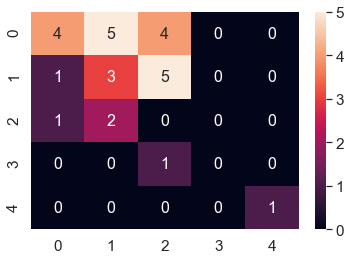

In [27]:
import seaborn as sn

array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()